# Flat-top and ramp-up labelling with multiple segments (improved)
I realised that a single flat-top can't capture the true flat-top. In many cases, the flat-top is not a perfect plateau, it can contain spikes. So, I switched to a divide-and-conquer strategy. Instead of forcing one flat-top, I allowed multiple flat-top segments to be detected independently using the same standard deviation 
check and an added masking rules (e.g., above a minimum Ip, before disruption).

Comnbining these segments was straightforward. Please read the comments in `combine_segments` method.


## Download the data
Code to download just the summary from CSD3.

```bash
for i in {30001..30472}; do                                         
  rsync -avz --progress CSD3:/rds/project/rds-mOlK9qn0PlQ/fairmast/upload-tmp/level2/${i}.zarr/summary/ ~/Downloads/level2_summary/${i}/
done
```

In [427]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

In [428]:
shot_ids_i_like = [30108, 30121, 30178, 30035, 30183, 30086, 30112, 30109, 30209]
# random shots ints
np.random.seed(0)
shot_ids = np.random.randint(30000, 30200, 40).tolist()
shot_ids = list(shot_ids) + shot_ids_i_like
shot_ids = sorted(set(shot_ids))  # remove duplicates and sort

shot_ids

[30009,
 30021,
 30025,
 30029,
 30035,
 30036,
 30039,
 30047,
 30058,
 30067,
 30070,
 30072,
 30077,
 30079,
 30081,
 30082,
 30086,
 30087,
 30088,
 30099,
 30103,
 30108,
 30109,
 30112,
 30115,
 30117,
 30121,
 30140,
 30142,
 30147,
 30148,
 30165,
 30167,
 30172,
 30174,
 30175,
 30177,
 30178,
 30183,
 30192,
 30193,
 30195,
 30197,
 30209]

In [429]:
def detect_change_points(time, intensity, window_size=50, threshold=2.0):
    """
    Detects change points based on the difference in moving average intensity.

    Args:
    - time (np.array): Time array.
    - intensity (np.array): Intensity array.
    In level 1 data, plasma current is in kA, in level 2 data it is in Amps. So, we divide by 1000 to get kA.
    Otherwise, the gradient will be too high.
    - window_size (int): Size of the window for calculating moving average.
    - threshold (float): Threshold for detecting significant changes.

    Returns:
    - change_points (list): List of times when significant changes are detected.
    """
    moving_avg = np.convolve(intensity/1000, np.ones(window_size) / window_size, mode='valid')
    diff = np.abs(np.diff(moving_avg))

    change_indices = np.where(diff > threshold)[0] + window_size  # Adjust index for valid region
    change_points = time[change_indices]

    # If no change points detected, return None
    if len(change_points) == 0:
        return None

    return change_points

In [430]:
class DisruptionDetector:
    def __init__(
        self,
        ip_threshold=60.0,
        disruption_window=0.05,
        disruption_window_size=50,
        disruption_poly_order=2,
        disruption_prominence=10.0,
        flat_top_window_size=51,
        flat_top_tolerance=0.01,
        flat_top_interp_kind="linear",
        rampup_window_size = 20,
        min_duration=0.02,
        plot=False
    ):
        # disruption detection
        self.ip_threshold = ip_threshold
        self.disruption_window = disruption_window
        self.disruption_window_size = disruption_window_size
        self.disruption_poly_order = disruption_poly_order
        self.disruption_prominence = disruption_prominence

        # flat top
        self.flat_top_window_size = flat_top_window_size
        self.flat_top_tolerance = flat_top_tolerance
        self.flat_top_interp_kind = flat_top_interp_kind
        self.rampup_window_size = rampup_window_size
        self.min_duration = min_duration
        self.plot = plot

    def _detect_flattop(self, ip, time, td=None):
        """
        Detects the flat-top region of the plasma current using standard deviation based wobbliness check.
        """

        try:
            # Only search before disruption (if given), to avoid false flat region after crash
            # we use masking becasue standard deviation detects post disruption as a flat top.
            if td is None:
                print("td is none. can't mask post disruption zone.")
            if td is not None:
                mask = time < td
                ip = ip[mask]
                time = time[mask]

            # Compute rolling standard deviation to find "flat" regions
            window_pts = self.flat_top_window_size
            ip_series = pd.Series(ip)
            rolling_std = ip_series.rolling(window_pts, center=True).std() # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

            # Identify indices where the std is below threshold (i.e., flat)
            flat_idxs = np.where(rolling_std < self.flat_top_tolerance)[0]
            #print(f"DEBUG: flat_idxs count = {len(flat_idxs)}")

            if len(flat_idxs) == 0:
                return np.nan, np.nan

            # Split into continuous segments
            diffs = np.diff(flat_idxs)
            split_idx = np.where(diffs > 1)[0]
            segments = np.split(flat_idxs, split_idx + 1)

            # Pick the longest continuous flat segment
            longest = max(segments, key=len)

            # Extract start and end times
            tmin = time[longest[0]]
            tmax = time[longest[-1]]
            return tmin, tmax

        except Exception as e:
            print(f"Flat-top detection failed: {e}")
            return np.nan, np.nan
    def detect_all_flattops(self, ip, time, td, min_duration=0.002, max_iters=10):
        ip = np.array(ip)
        time = np.array(time)
        ip_masked = ip.copy()
        ip_masked[ip < 2e4] = np.nan  # already decided on 20k threshold
        ip_masked[time >= td] = np.nan  # td cut

        segments = []

        for _ in range(max_iters):
            ft_start, ft_end = self._detect_flattop(ip_masked, time, td) # need to modify the flattop detection fucntion to not use td every single time, since it is being masked here.

            if np.isnan(ft_start) or np.isnan(ft_end):
                break

            duration = ft_end - ft_start
            if duration < min_duration:
                print(f"Segment too short: {duration:.4f}s — stopping.")
                break # stop the loop because we are finding flat-tops that are too short and meaningless, as it can be a flat line on the rampup area.

            segments.append((ft_start, ft_end))
            ip_masked[(time >= ft_start) & (time <= ft_end)] = np.nan  # mask used part

        return segments

    def _detect_rampup_simple(self, flat_top_start):
        return 0.0, flat_top_start

    def _detect_rampup(self, ip, time, flat_top_start):
        try:
            if np.isnan(flat_top_start):
                return 0.0, np.nan  # can't proceed if flattop start is NaN, sure there is a better way to do this.

            # Use data before flat-top only
            mask = time <= flat_top_start
            ip = ip[mask]
            time = time[mask]

            # Enforce minimum ramp-up duration
            time_mask = time > 0.05
            ip = ip[time_mask]
            time = time[time_mask]

            # mast anything before flat top start -0.1
            time_mask = time > flat_top_start - 0.2
            ip = ip[time_mask]
            time = time[time_mask]

            # Compute rolling gradient
            ip_smooth = pd.Series(ip).rolling(window=self.rampup_window_size, center=True).mean()
            grad = np.gradient(ip_smooth)
            grad = np.nan_to_num(grad)

            # Ramp-up ends when gradient drops below a small threshold
            grad_thresh = 0.5 * np.nanmax(grad)
            # candidate_idxs = np.where(grad < grad_thresh)[0]

            # if len(candidate_idxs) == 0:
            #     return 0.0, flat_top_start

            # # Find first place where gradient becomes low (end of strong ramp)
            # t_ramp_end = time[candidate_idxs[-2]]

            high_grad_idxs = np.where(grad > grad_thresh)[-1]
            if len(high_grad_idxs) == 0:

                t_ramp_end = flat_top_start
            else:
                t_ramp_end = time[high_grad_idxs[-1]]
            return 0.0, t_ramp_end

        except Exception as e:
            print(f"Ramp-up detection failed: {e}")
            return 0.0, flat_top_start

    def combine_segments(self, segments):
        """
        Sure I can use smart techniques to combines the segments, such as implement a distance parameter.
        But based on my plots, I think we can just take the min and max of the segments. I know this is stupid, but it works.
        The problem is there are huge spikes within the flattop but our iterative algo is able to find correct flat segments in the flattops irrespective of the distance.
        So I think we can just take the min and max of the segments.
        """
        if not segments:
            return np.nan, np.nan
        starts, ends = zip(*segments)
        return min(starts), max(ends)


    def run(self, shot, ip, time):
        # remove early garbage
        mask = time >= 0
        ip = ip[mask]
        time = time[mask]

        change_points = detect_change_points(time, ip, window_size=self.disruption_window_size, threshold=self.disruption_prominence)
        td = change_points[-1] if change_points is not None and len(change_points) > 0 else np.nan

        flattop_segments = self.detect_all_flattops(ip, time, td, self.min_duration)

        # # For now, just take the earliest segment as representative
        # if flattop_segments:
        #     ft_start, ft_end = flattop_segments[0]
        # else:
        #     ft_start, ft_end = np.nan, np.nan
        ft_start, ft_end = self.combine_segments(flattop_segments) # combine all segments and calc start and end of flattop

        #ru_start, ru_end = self._detect_rampup(ft_start)  # can stay as-is for now
        ru_start, ru_end = self._detect_rampup(ip, time, ft_start)

        if self.plot:
            self._plot_with_segments(shot, ip, time, flattop_segments, td, ru_start, ru_end)

        return {
            "shot": shot,
            "td": td,
            "flattop_start": ft_start,
            "flattop_end": ft_end,
            "rampup_start": ru_start,
            "rampup_end": ru_end,
            "flattop_segments": flattop_segments,  # all segments so we can plot and see what is going on
        }

In [431]:
# larger window and threshold for standard deviation based flatness check
params = {
    "ip_threshold": 60.0,
    "disruption_window": 0.05,
    "disruption_window_size": 20,
    "disruption_poly_order": 2,
    "disruption_prominence": 10,
    "flat_top_window_size": 100,
    "flat_top_tolerance": 10000,
    "flat_top_interp_kind": "linear",
    "rampup_window_size": 50,
    "min_duration" : 0.02,
}

In [432]:
results = []

for shot in shot_ids:
    try:
        ds = xr.open_zarr(f"./level2_copy/{shot}", consolidated=False)
    except :
        print(f"File not found for shot {shot}. Skipping.")
        continue
    ip = ds["ip"].values
    time = ds["time"].values

    detector = DisruptionDetector(**params)
    result = detector.run(shot, ip, time)
    results.append(result)
  

df = pd.DataFrame(results)


File not found for shot 30025. Skipping.
Segment too short: 0.0163s — stopping.
Segment too short: 0.0140s — stopping.
Segment too short: 0.0185s — stopping.
File not found for shot 30070. Skipping.
File not found for shot 30072. Skipping.
File not found for shot 30079. Skipping.
File not found for shot 30082. Skipping.
Segment too short: 0.0145s — stopping.
Segment too short: 0.0005s — stopping.
Segment too short: 0.0078s — stopping.
Segment too short: 0.0117s — stopping.


In [433]:
df.head()

,shot,td,flattop_start,flattop_end,rampup_start,rampup_end,flattop_segments
0,30009,0.18440,0.13240,0.15915,0.0,0.12590,"[(0.1323997106552126, 0.15914971065521266)]"
1,30021,0.48880,0.12755,0.44855,0.0,0.12005,"[(0.12754970932006857, 0.4485497093200689)]"
2,30029,0.17915,NaN,NaN,0.0,NaN,[]
3,30035,0.21515,NaN,NaN,0.0,NaN,[]
4,30036,0.35580,0.21905,0.33380,0.0,0.17230,"[(0.21904973506927516, 0.3337997350692753)]"


In [434]:
df.shape[0], df.isnull().sum(axis=0)

(39,
 shot                0
 td                  3
 flattop_start       5
 flattop_end         5
 rampup_start        0
 rampup_end          5
 flattop_segments    0
 dtype: int64)

In [435]:
def plot_single_shot(shot_id, ip, time, labels_dict):
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    #label_names = ['rampup_start', 'rampup_end', 'flattop_start', 'flattop_end', 'td']
    label_names = [ 'td']
    plt.figure(figsize=(10, 4))
    plt.plot(time, ip)#, label="ip(t)")

    for i, label in enumerate(label_names):
        val = labels_dict.get(label, np.nan)
        if not np.isnan(val):
            plt.axvline(x=val, color=colors[i], linestyle='--', label=f"{label}={val:.3f}")
        else:
            plt.axvline(x=time[0], color=colors[i], linestyle=':', label=f"{label}=nan")
    # plot individual flat tops
    segments = labels_dict.get("flattop_segments", [])
    for i, (start, end) in enumerate(segments):
        plt.axvline(start, color="gray", linestyle="--", alpha=0.5)
        plt.axvline(end, color="gray", linestyle="--", alpha=0.5)
        plt.text((start + end)/2, max(ip)*0.5, f"FT{i}", ha="center", va="bottom", fontsize=8, color="gray")
    for i, (start, end) in enumerate(segments):
        # Get points within the segment for horizontal line level
        segment_mask = (time >= start) & (time <= end)
        if not np.any(segment_mask):
            continue
        segment_ip = ip[segment_mask]
        level = np.median(segment_ip)/2

        # Draw horizontal line and label
        plt.hlines(level, start, end, color="gray", linewidth=2, alpha=0.8)
           
    plt.xlabel("Time (s)")
    plt.ylabel("Plasma Current")
    plt.title(f"Shot {shot_id}")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()


In [436]:
for result in results:
    shot_id = result["shot"]
    ds = xr.open_zarr(f"./level2_copy/{shot_id}", consolidated=False)
    ip = ds["ip"].values
    time = ds["time"].values

    #plot_single_shot(shot_id, ip, time, result)

## Plot the important bits

In [437]:
def plot_single_shot(shot_id, ip, time, labels_dict):
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    label_names = ['rampup_start', 'rampup_end', 'flattop_start', 'flattop_end', 'td']
    #label_names = [ 'td']
    plt.figure(figsize=(10, 4))
    plt.plot(time, ip)#, label="ip(t)")

    for i, label in enumerate(label_names):
        val = labels_dict.get(label, np.nan)
        if not np.isnan(val):
            plt.axvline(x=val, color=colors[i], linestyle='--', label=f"{label}={val:.3f}")
        else:
            plt.axvline(x=time[0], color=colors[i], linestyle=':', label=f"{label}=nan")
    # horizontal flat-top bar
    ft_start = labels_dict.get("flattop_start", np.nan)
    ft_end = labels_dict.get("flattop_end", np.nan)
    if not np.isnan(ft_start) and not np.isnan(ft_end):
        mask = (time >= ft_start) & (time <= ft_end)
        if np.any(mask):
            ft_level = np.median(ip[mask])*0.5
            plt.hlines(ft_level, ft_start, ft_end, color="gray", linewidth=2, alpha=0.8)
            plt.text((ft_start + ft_end)/2, max(ip)*0.5, f"FT", ha="center", va="bottom", fontsize=8, color="gray")
    plt.xlabel("Time (s)")
    plt.ylabel("Plasma Current")
    plt.title(f"Shot {shot_id}")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()


/tmp/ipykernel_5014/2365406546.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


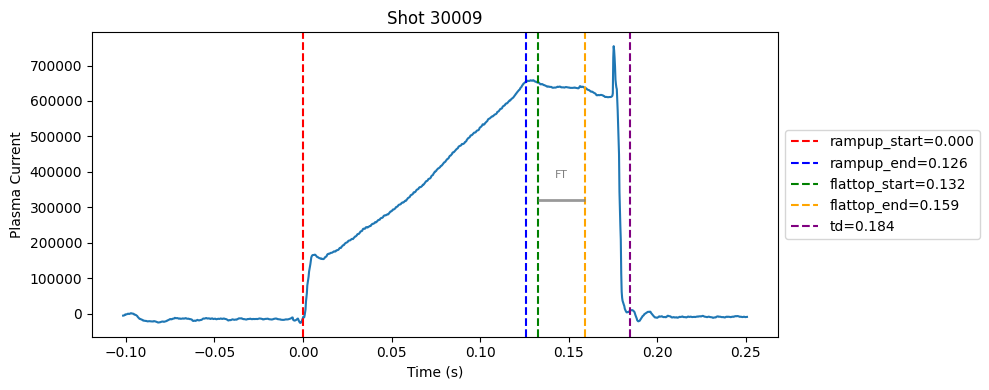

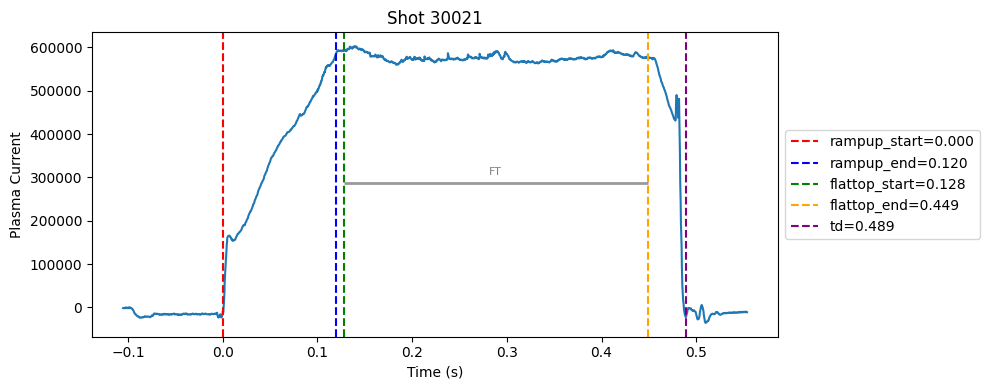

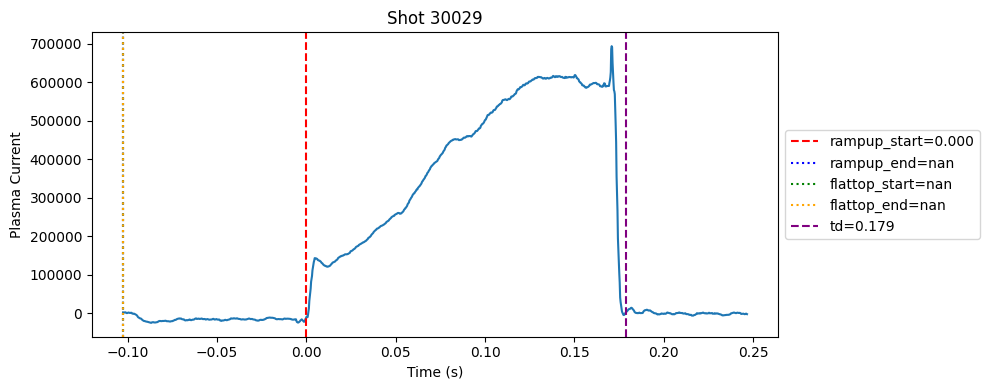

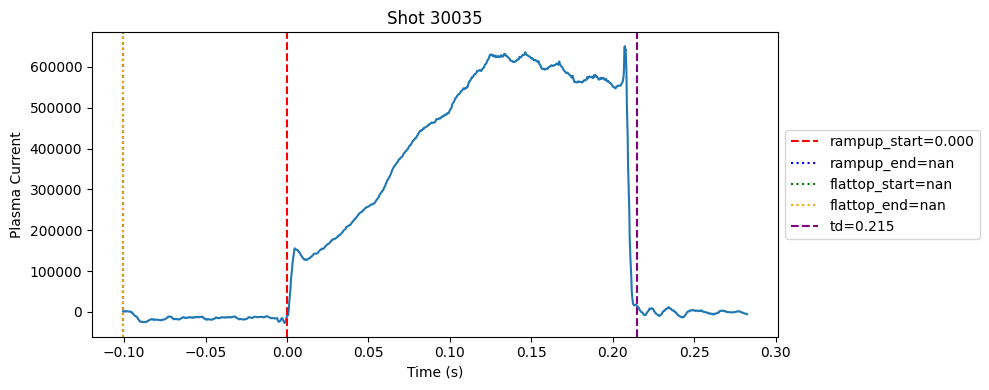

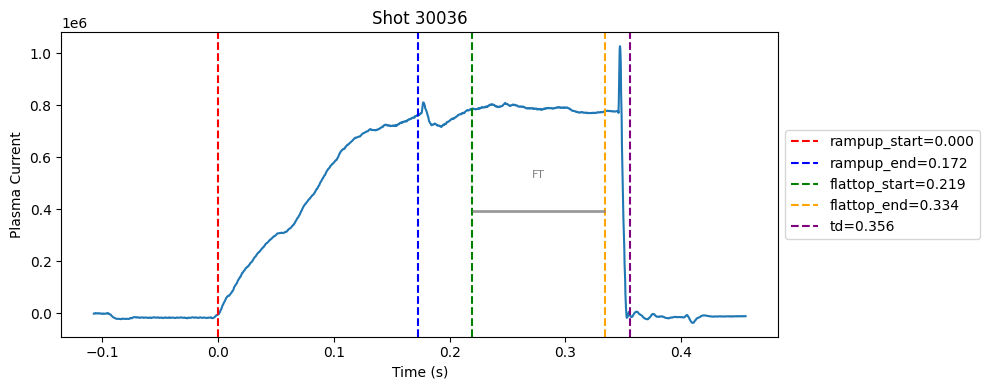

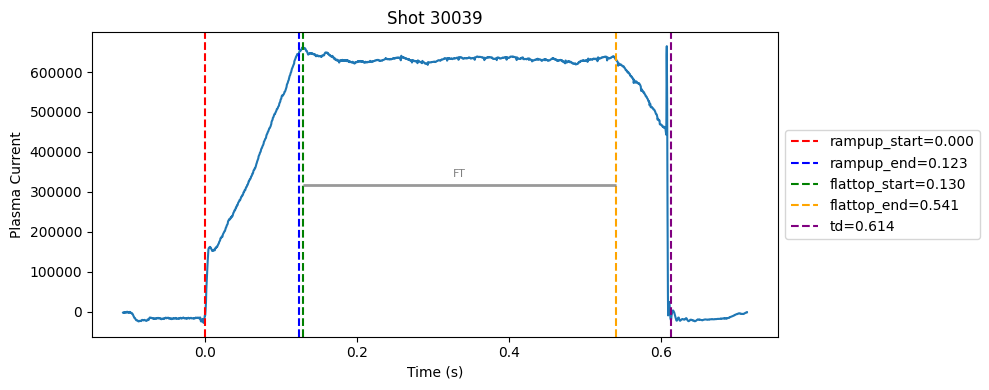

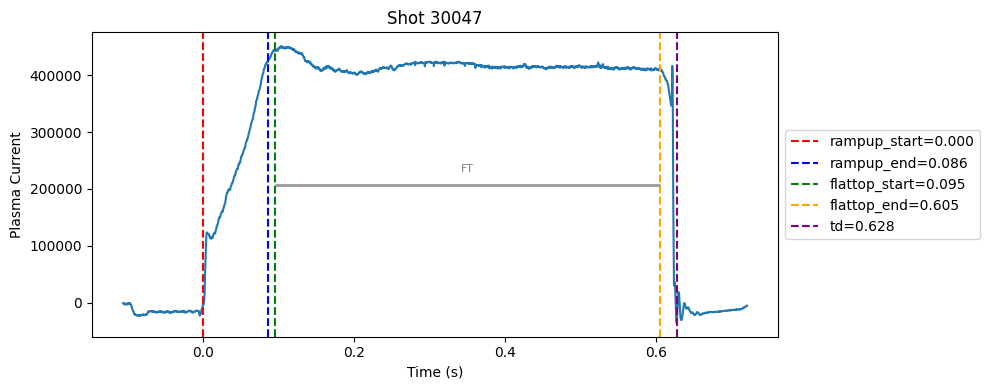

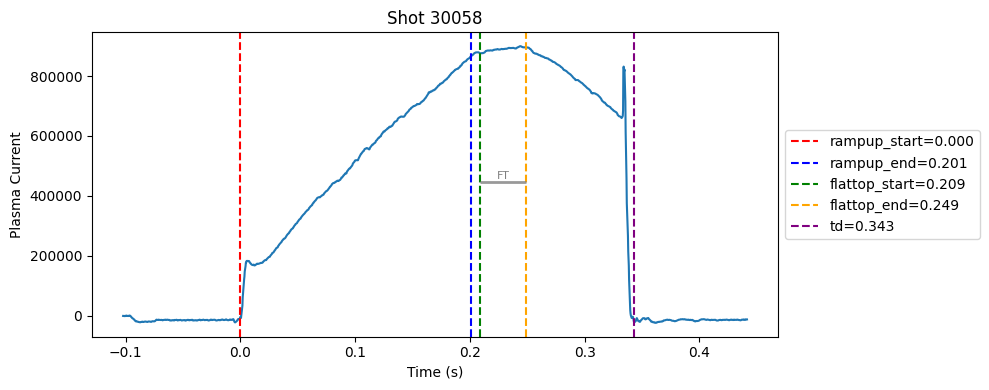

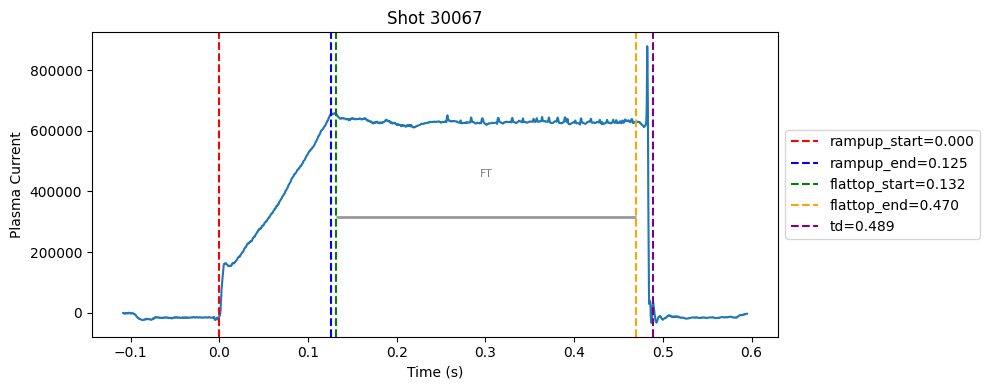

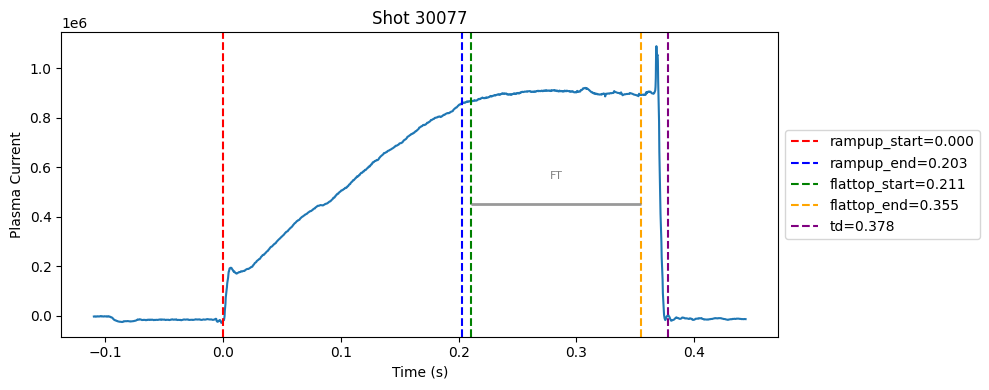

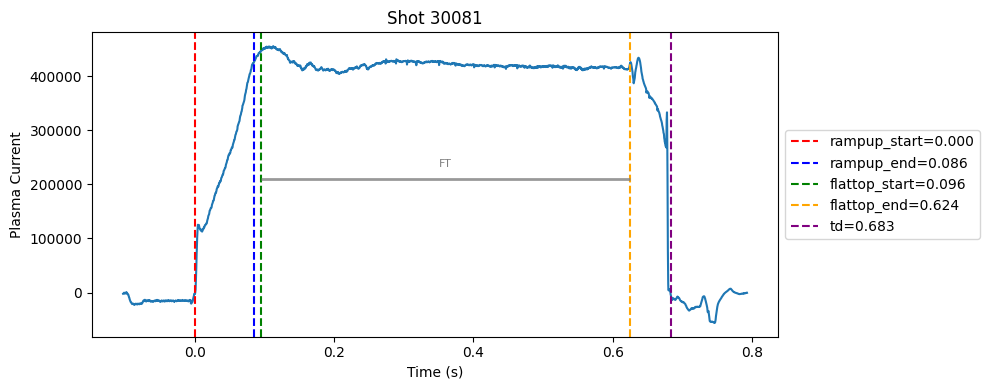

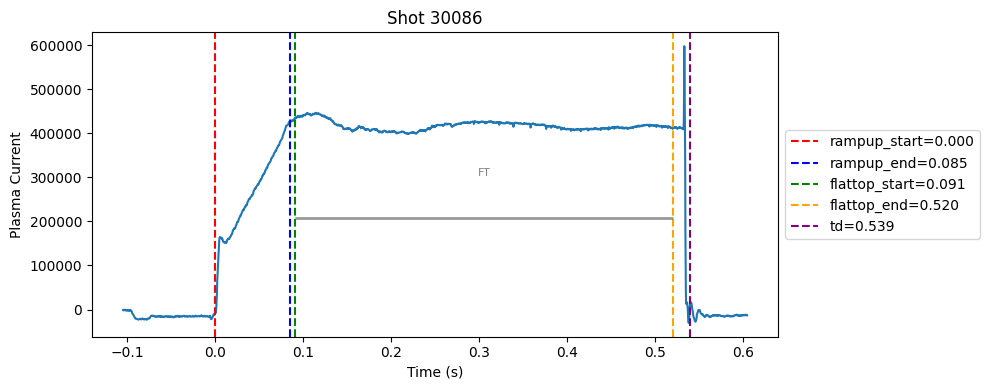

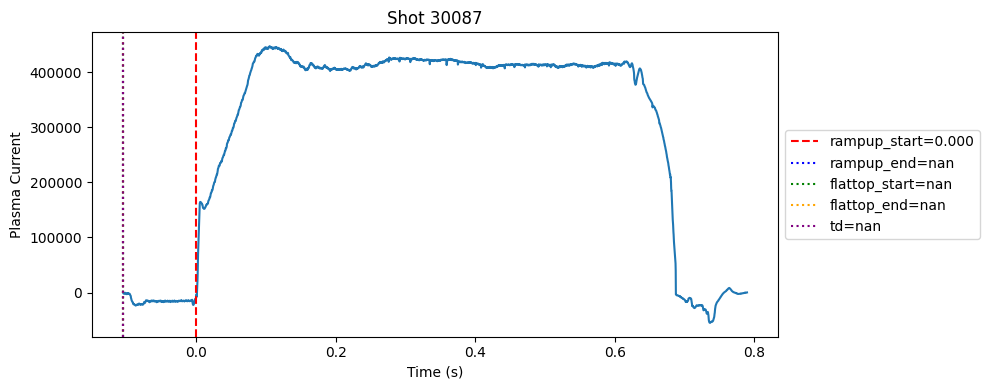

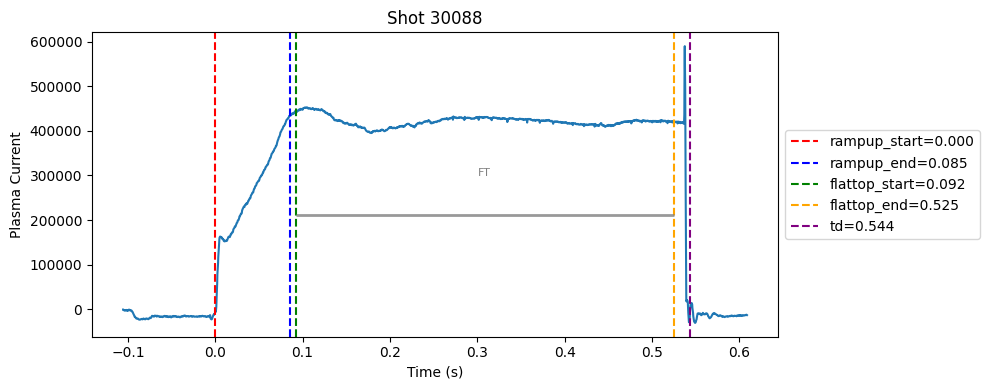

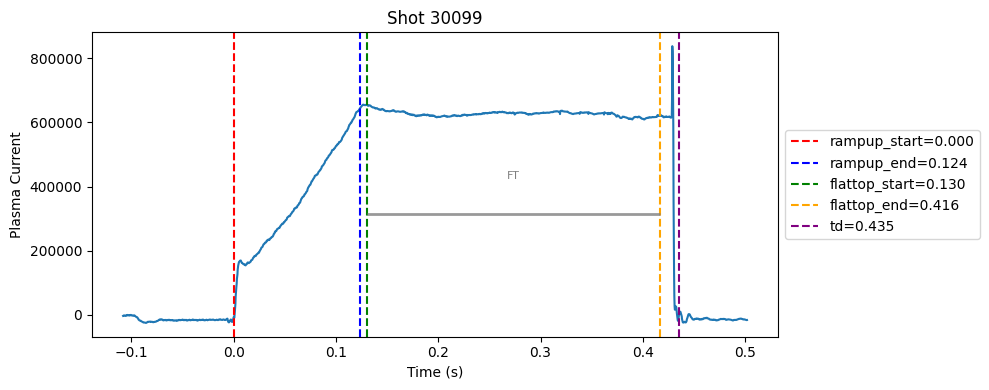

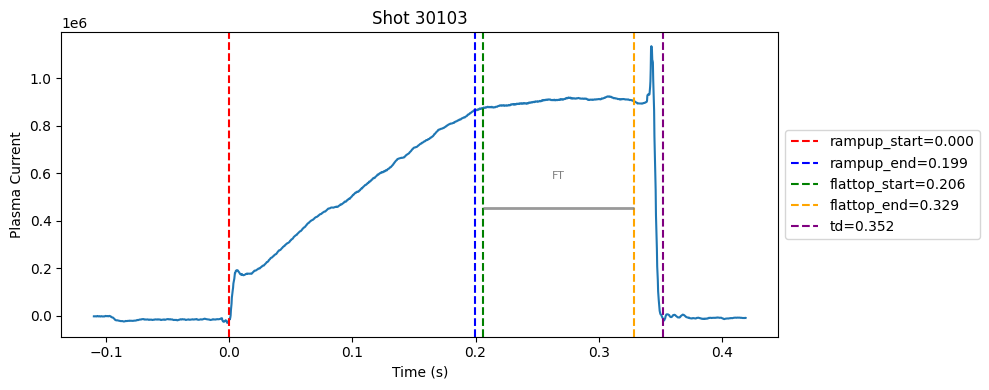

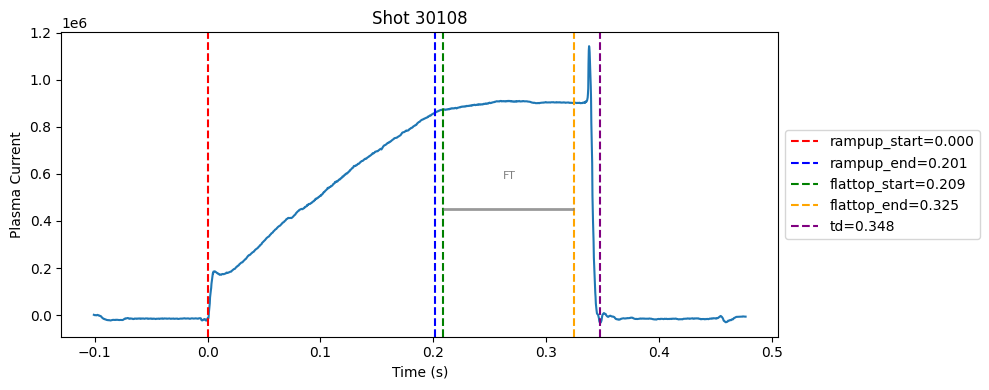

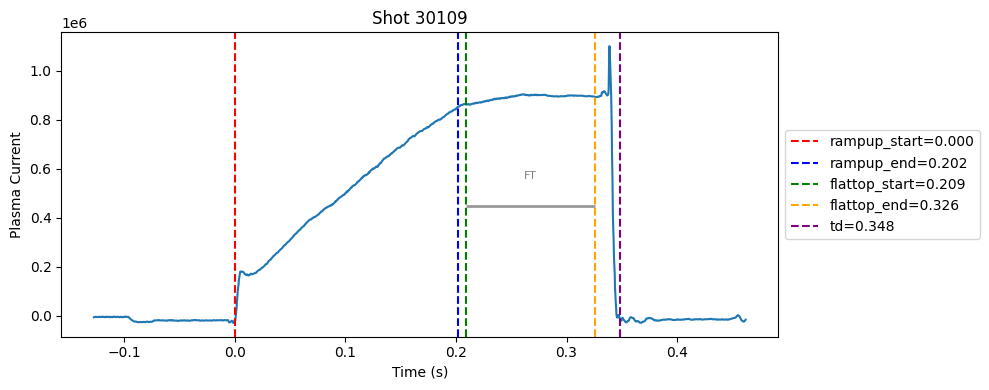

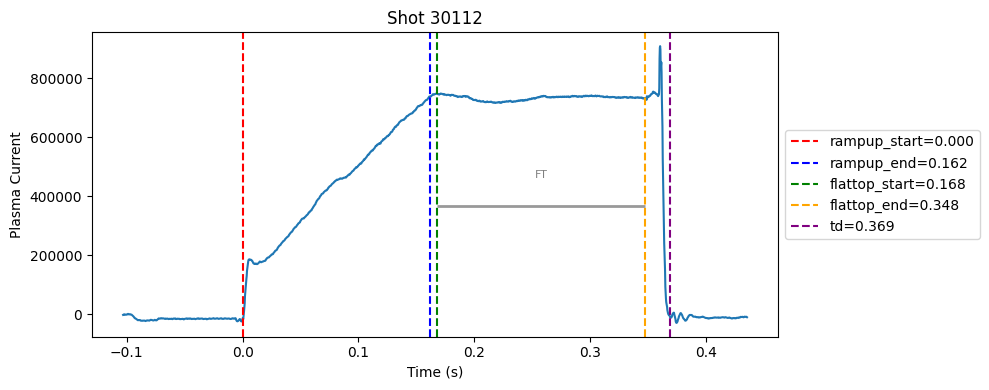

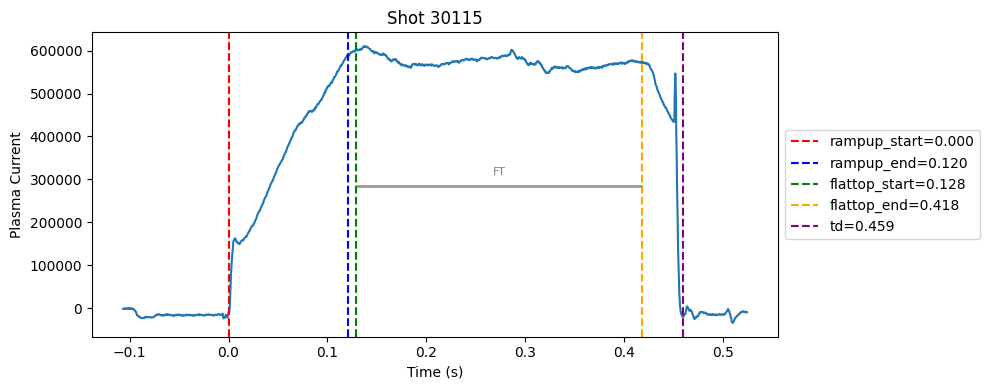

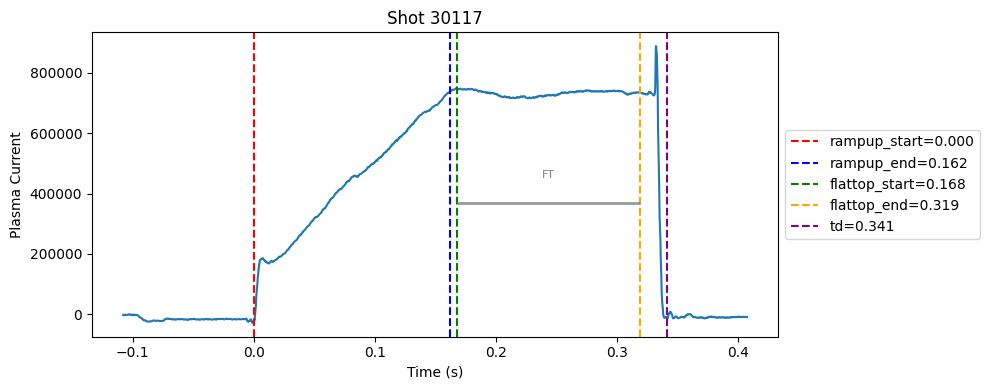

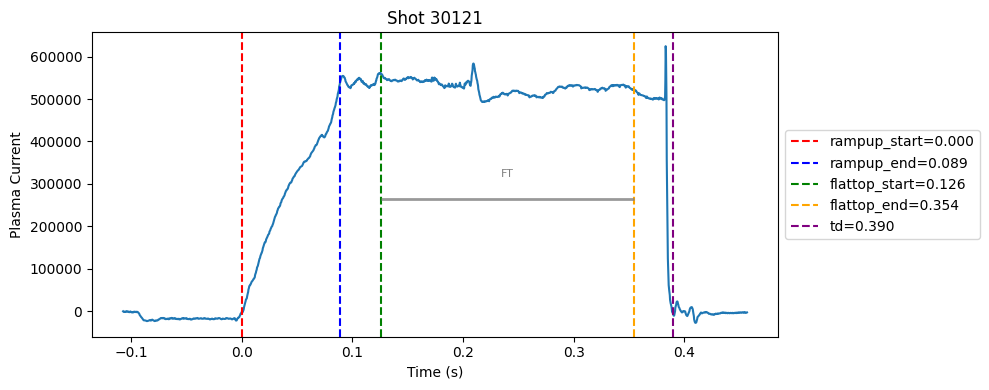

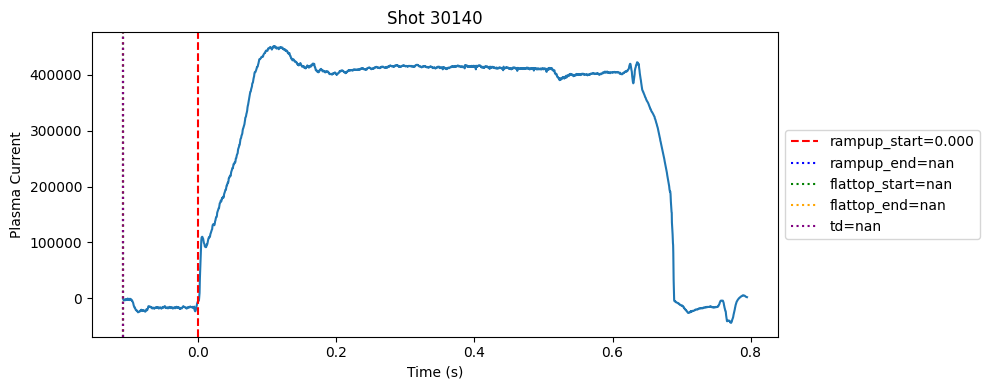

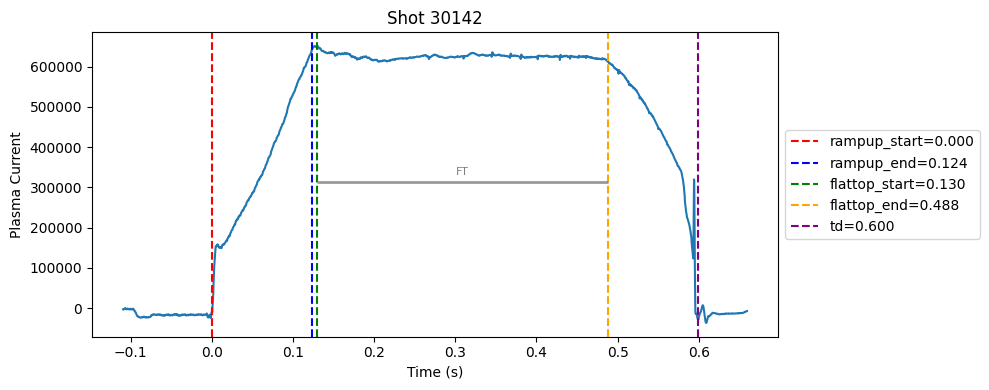

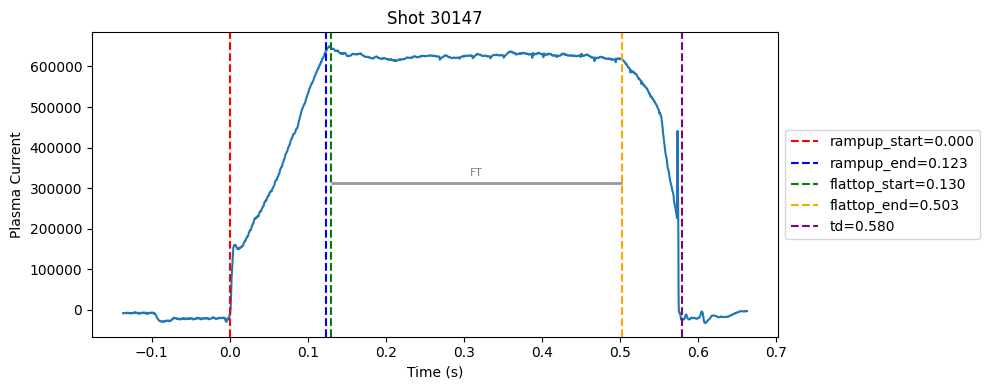

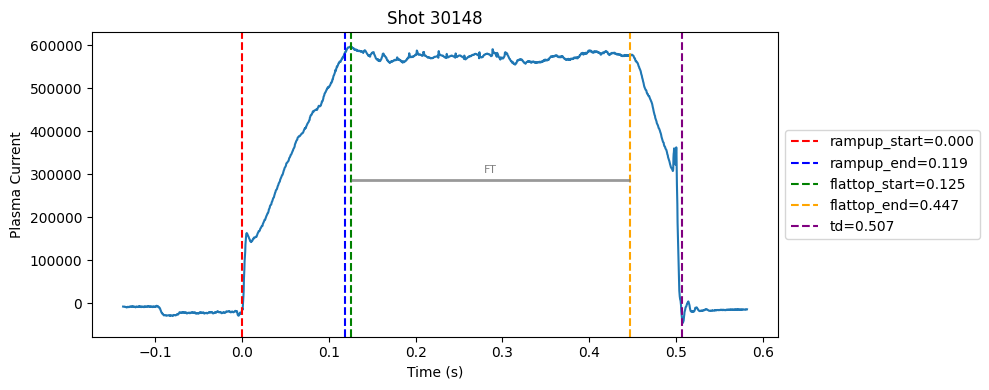

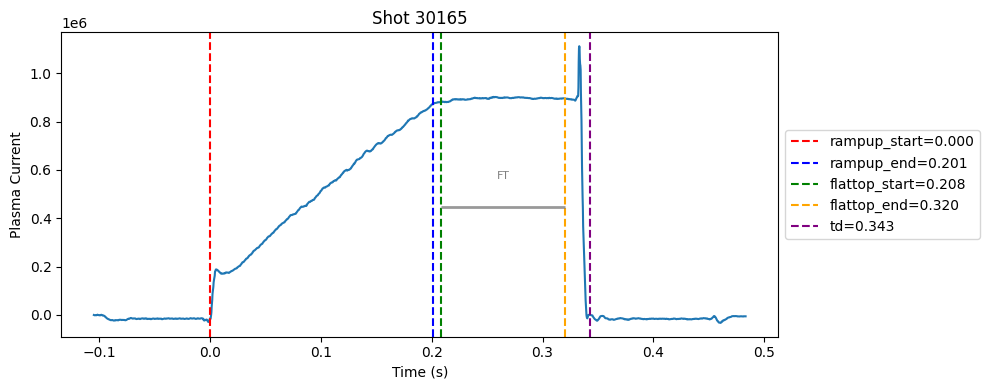

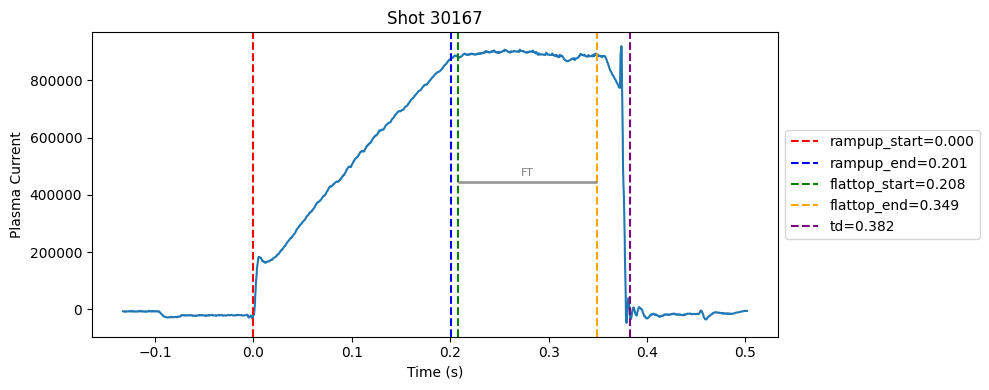

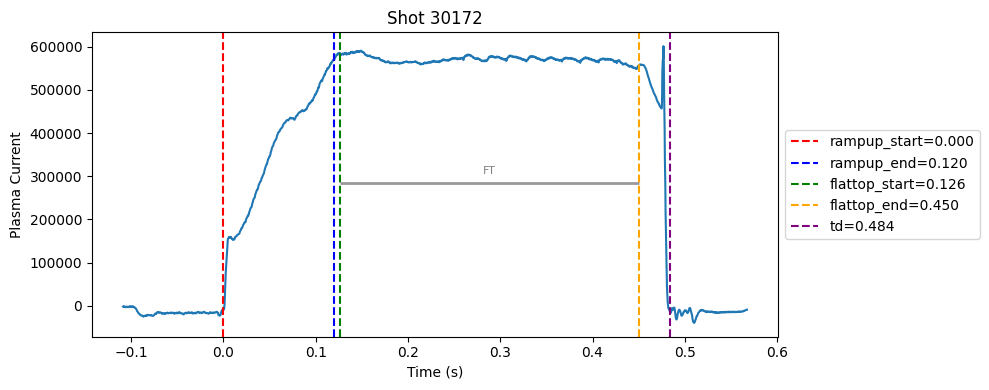

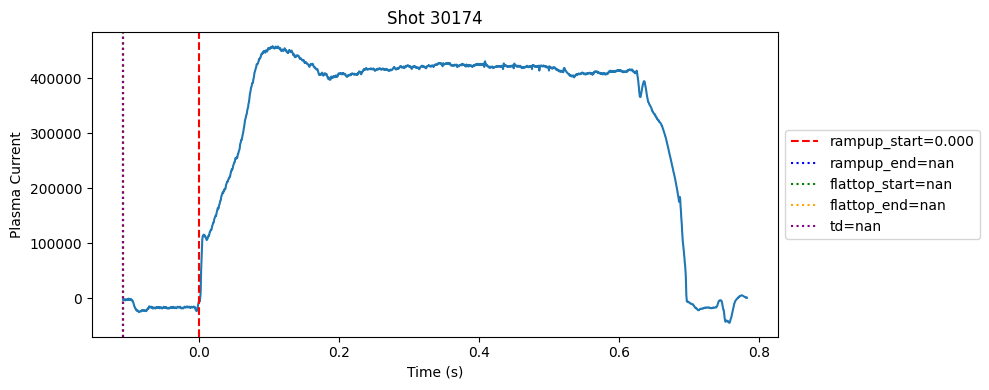

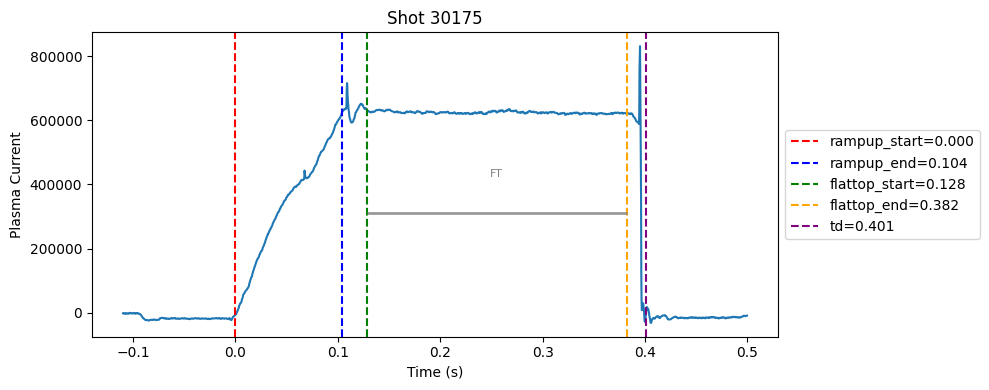

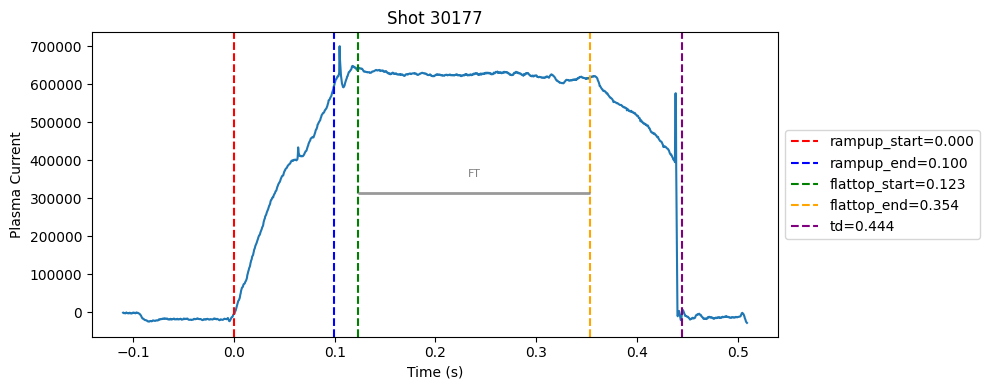

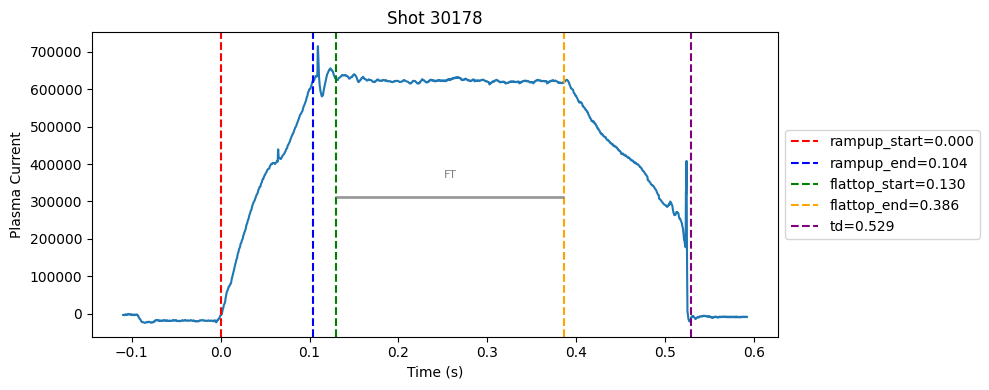

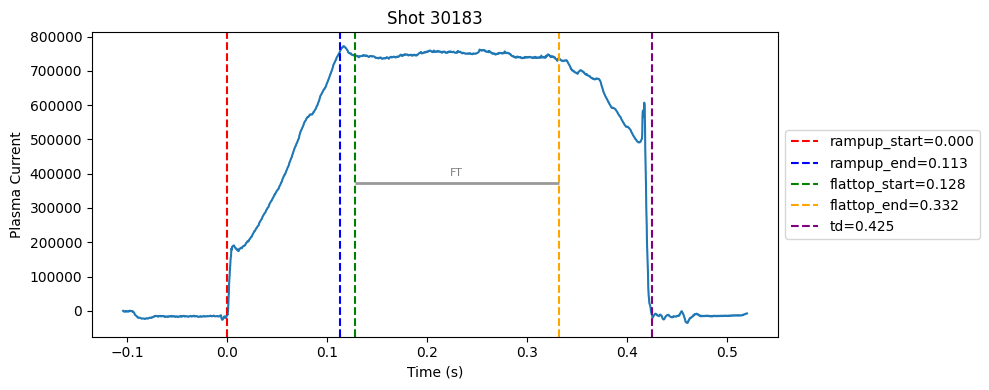

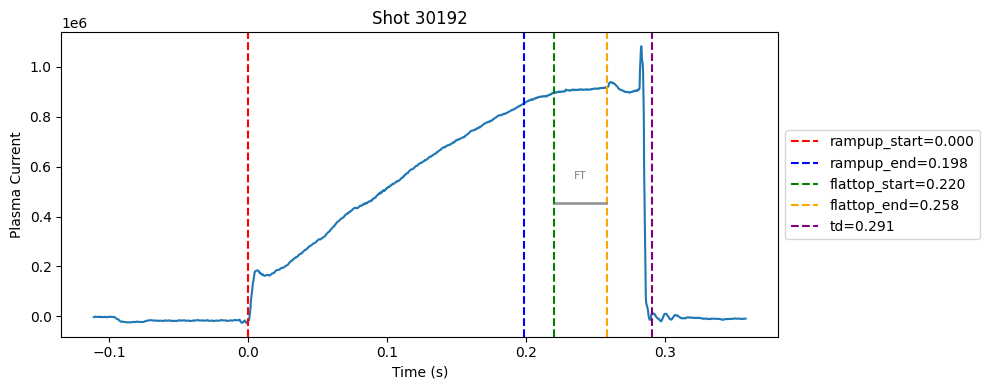

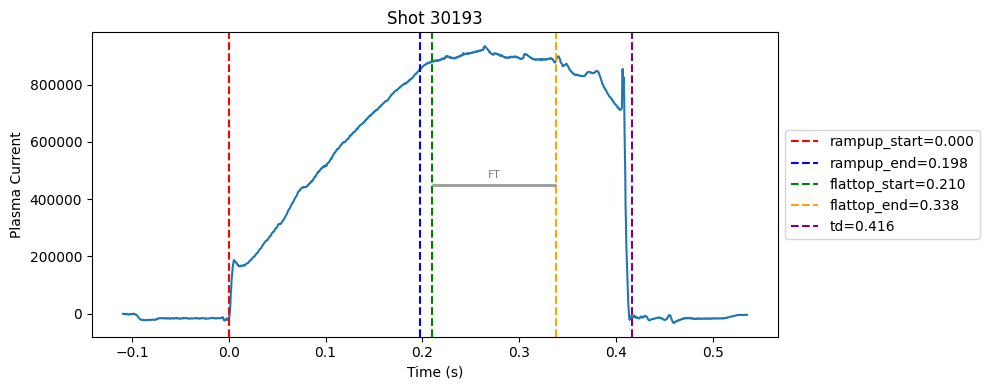

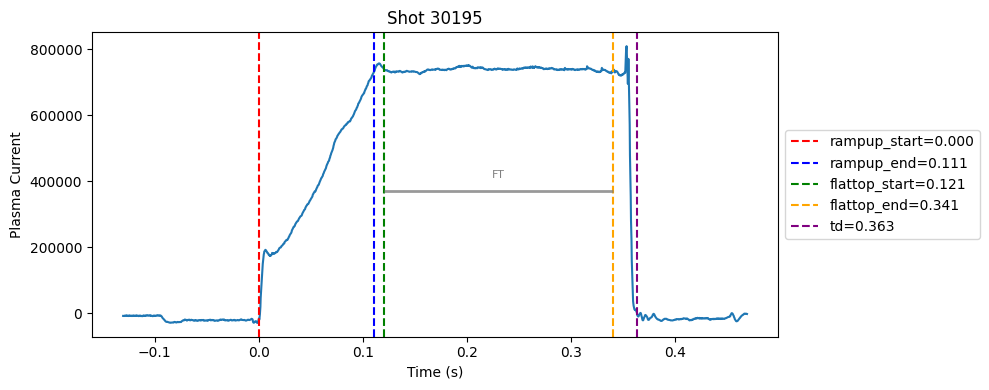

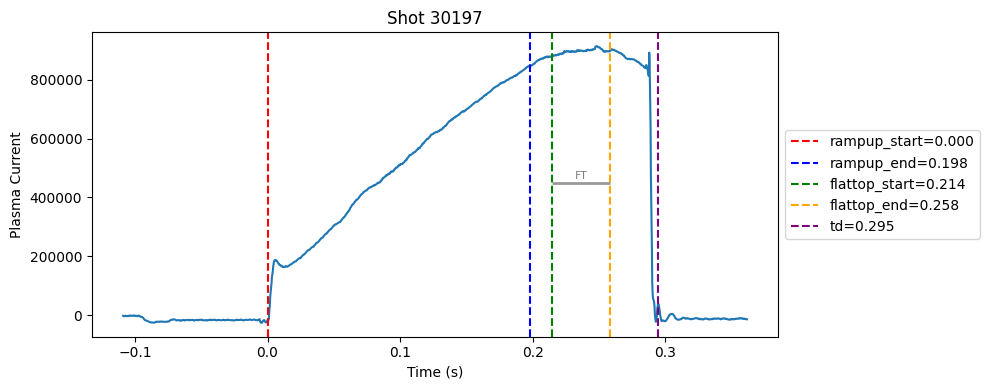

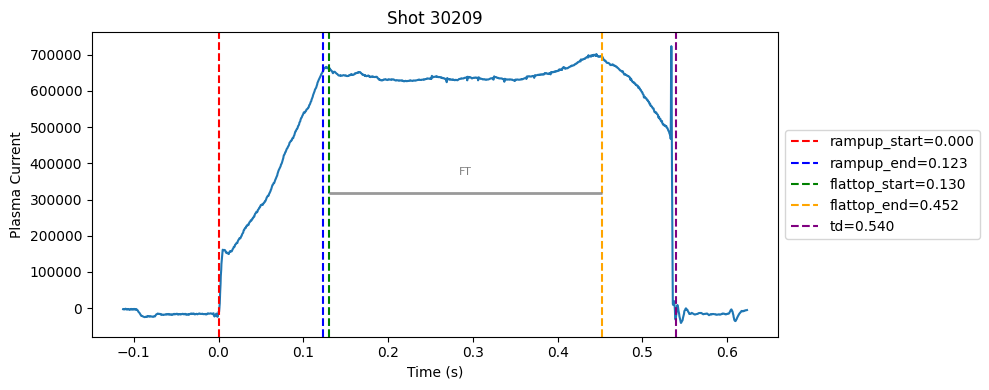

In [438]:
for result in results:
    shot_id = result["shot"]
    ds = xr.open_zarr(f"./level2_copy/{shot_id}", consolidated=False)
    ip = ds["ip"].values
    time = ds["time"].values

    plot_single_shot(shot_id, ip, time, result)